# 1: UNDERSTANDING THE PROBLEM STATEMENT AND BUSINESS CASE

<strong><i>The aim of the project is to classify 133 images into 4 classes (Healthy, COVID-19, Bacterial Pneumonia, and Viral Pneumonia) by using Convolutional Neural Network (CNN)<i><strong> 

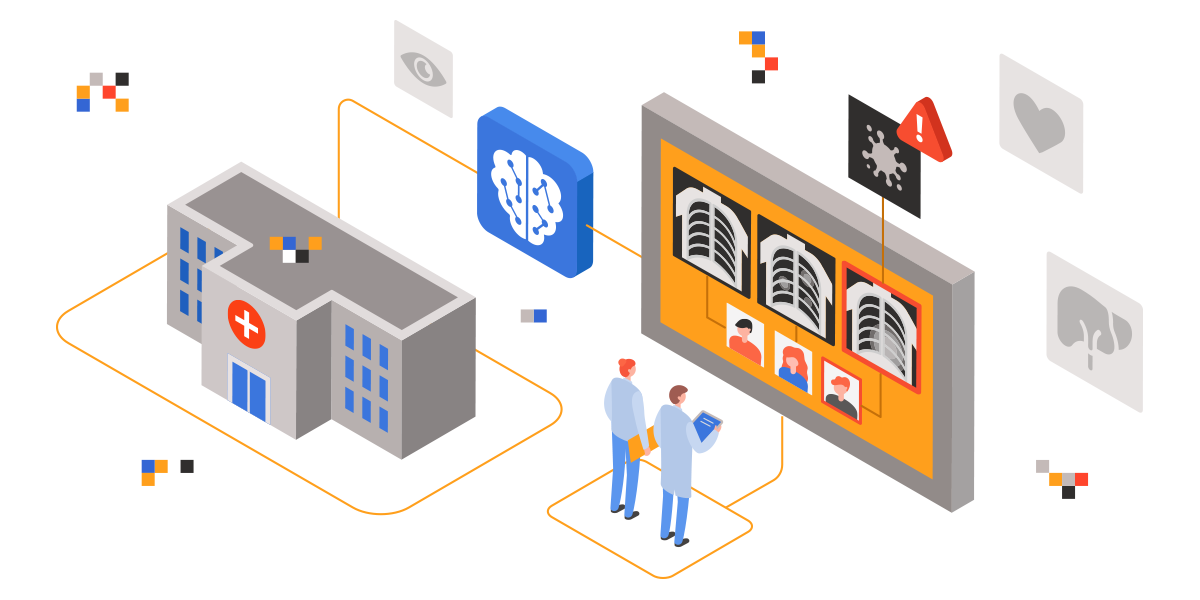

# 2: IMPORTING LIBRARIES AND DATASET

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [ ]:
# You will need to mount your drive using the following commands:
# For more information regarding mounting, please check this out: https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Specify training data directory
XRay_Directory = '/content/drive/My Drive/Colab Notebooks/Chest_X_Ray/train'

In [ ]:
# List the folders in the directory
os.listdir(XRay_Directory)

['3', '0', '1', '2']

In [ ]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation  
image_generator = ImageDataGenerator(rescale = 1./255, validation_split= 0.2)

In [ ]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing

train_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="training")


Found 428 images belonging to 4 classes.


In [ ]:
validation_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="validation")


Found 104 images belonging to 4 classes.


In [ ]:
# Generate a batch of 40 images and labels
train_images, train_labels = next(train_generator)


In [ ]:
train_images.shape

(40, 256, 256, 3)

In [ ]:
train_labels.shape

(40, 4)

In [ ]:
train_labels

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]],

In [ ]:
# labels Translator 
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

# 3: VISUALIZING DATASET

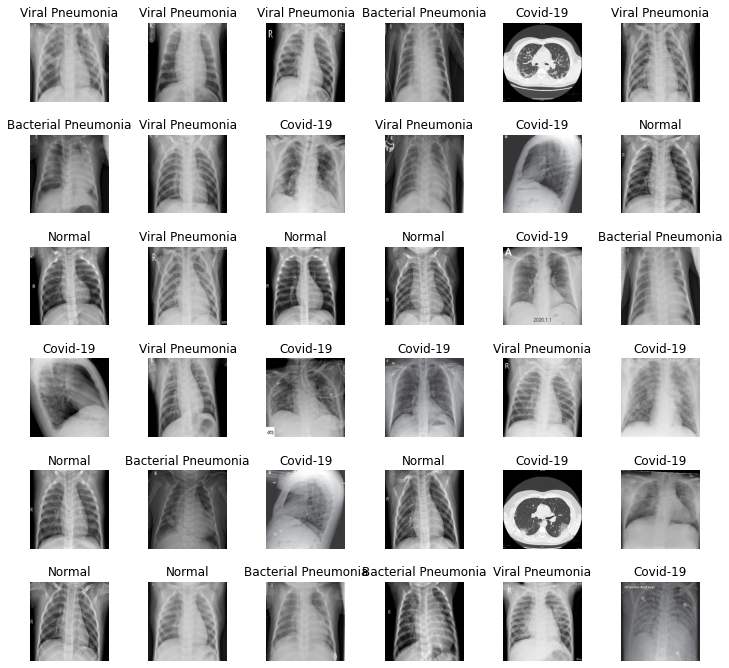

In [ ]:
# Create a grid of 36 images along with their corresponding labels
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)    

# 4: THEORY AND INTUITION BEHIND DEEP NEURAL NETWORKS

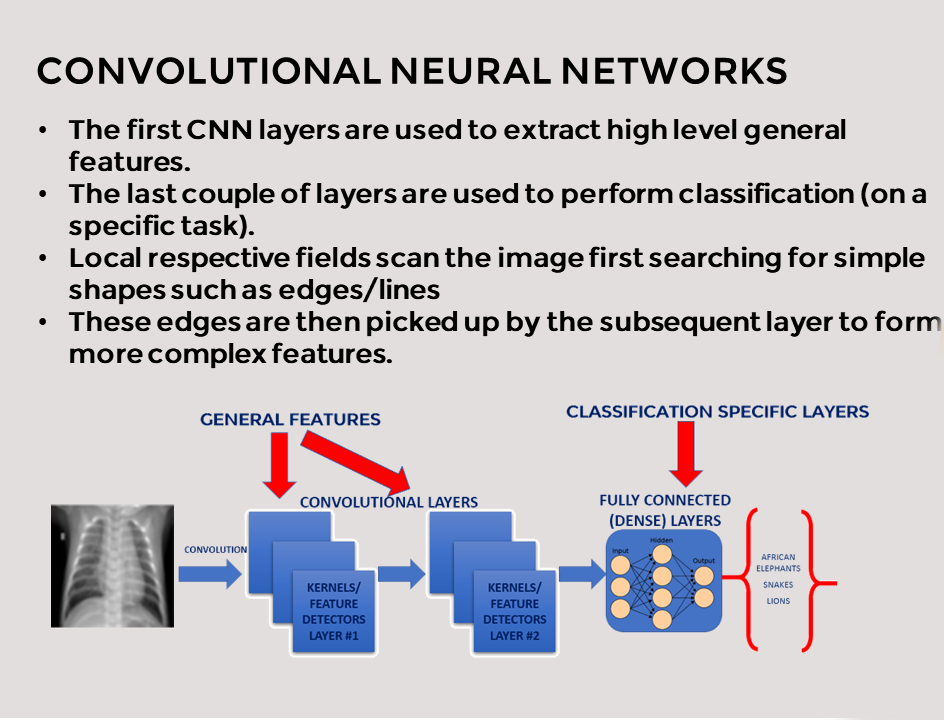

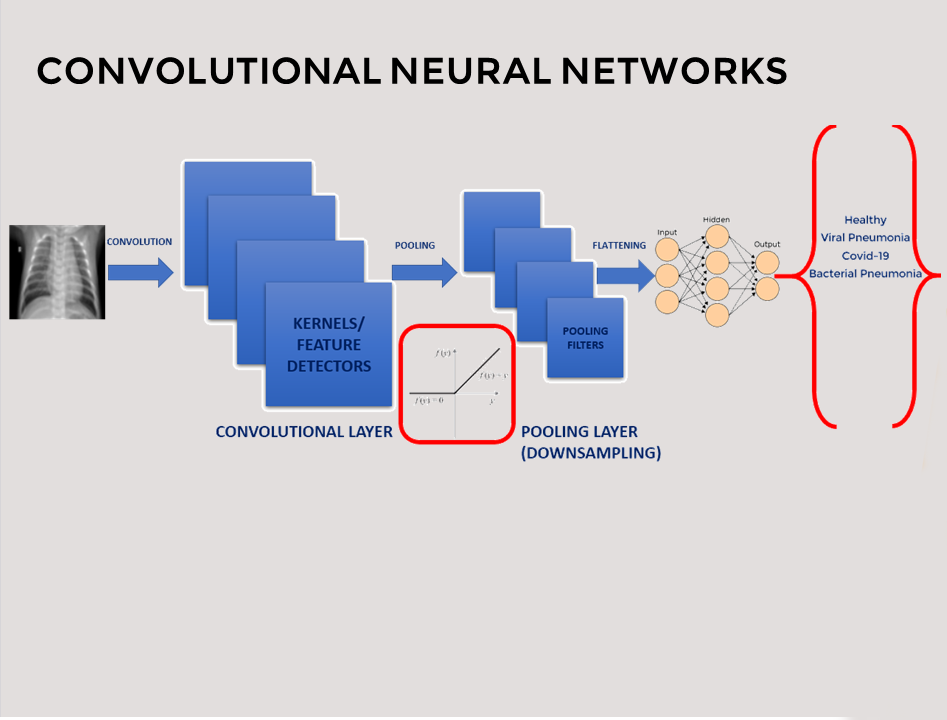

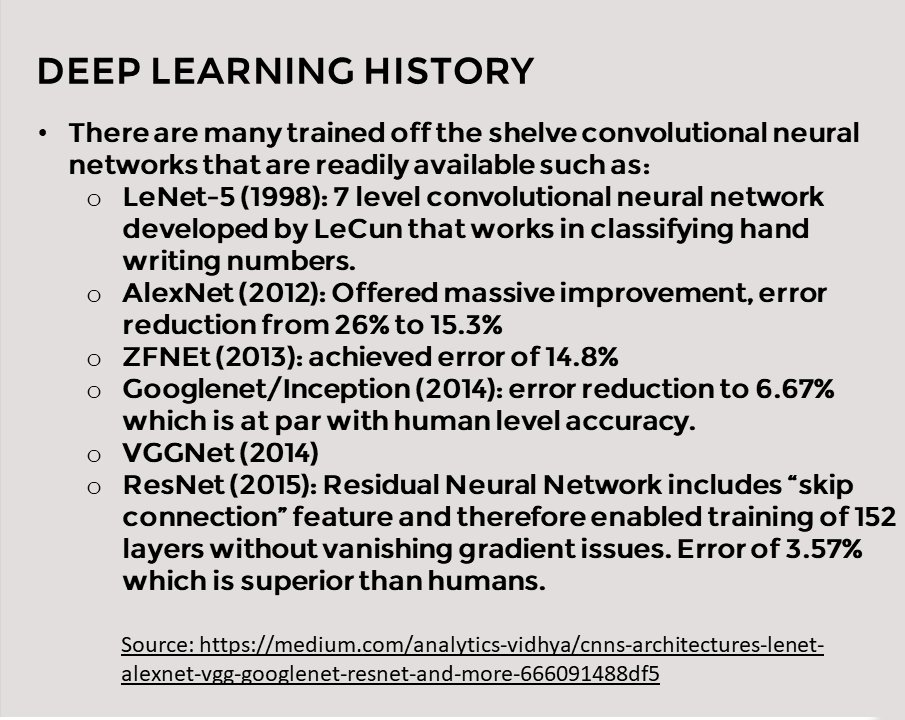

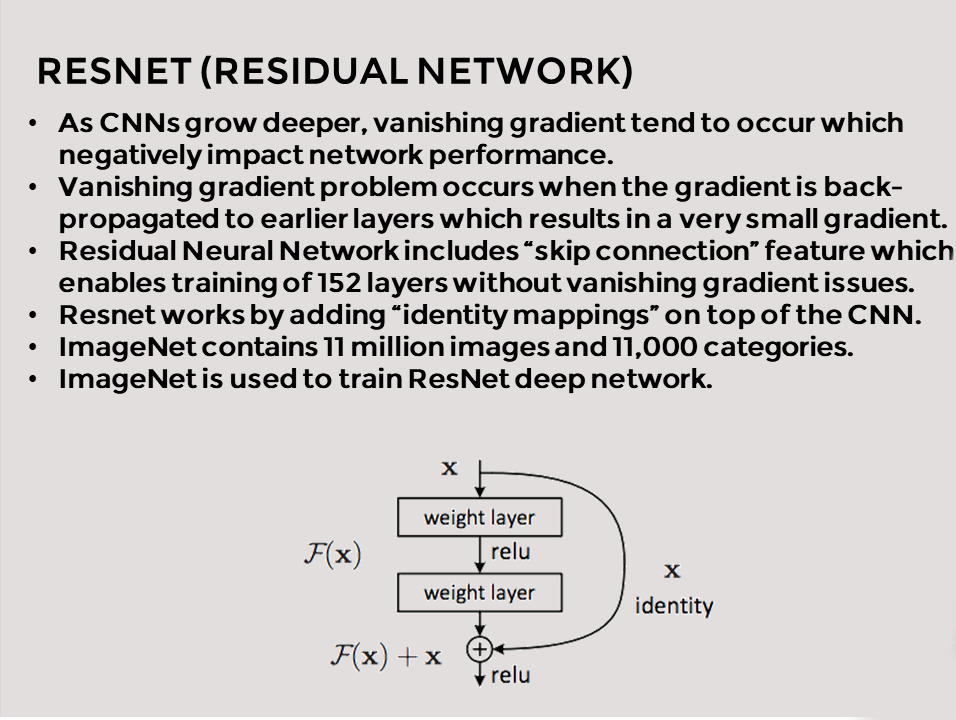

# 5: THEORY AND INTUITION BEHIND TRANSFER LEARNING

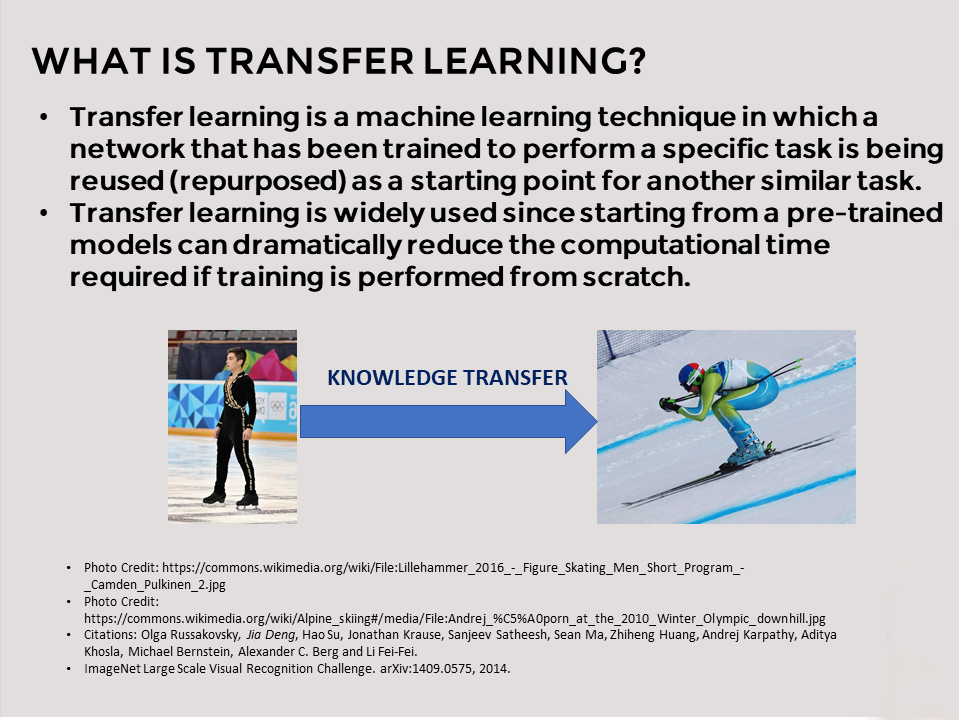

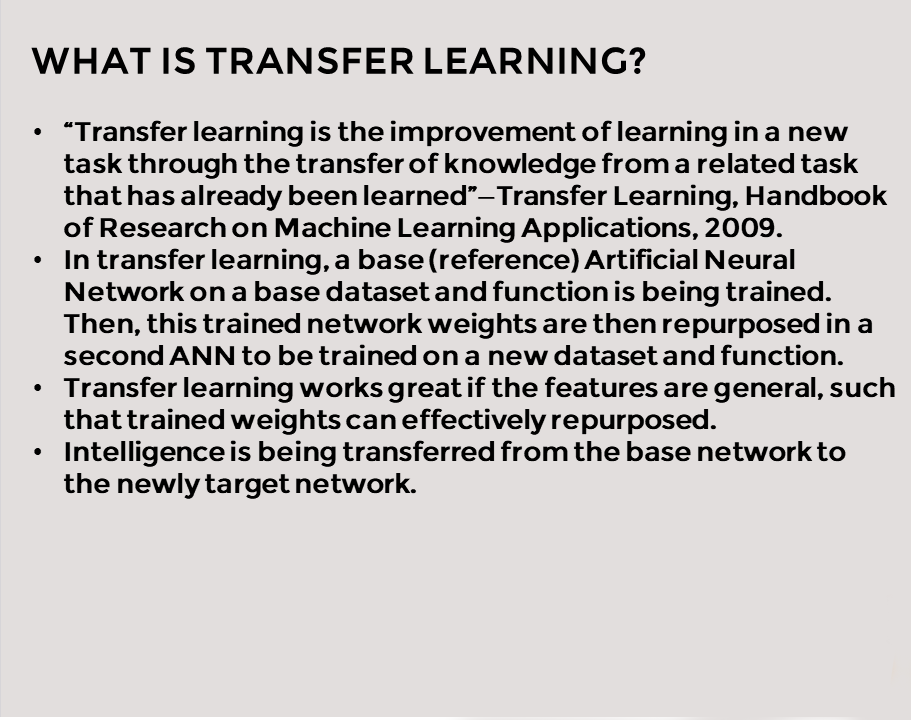

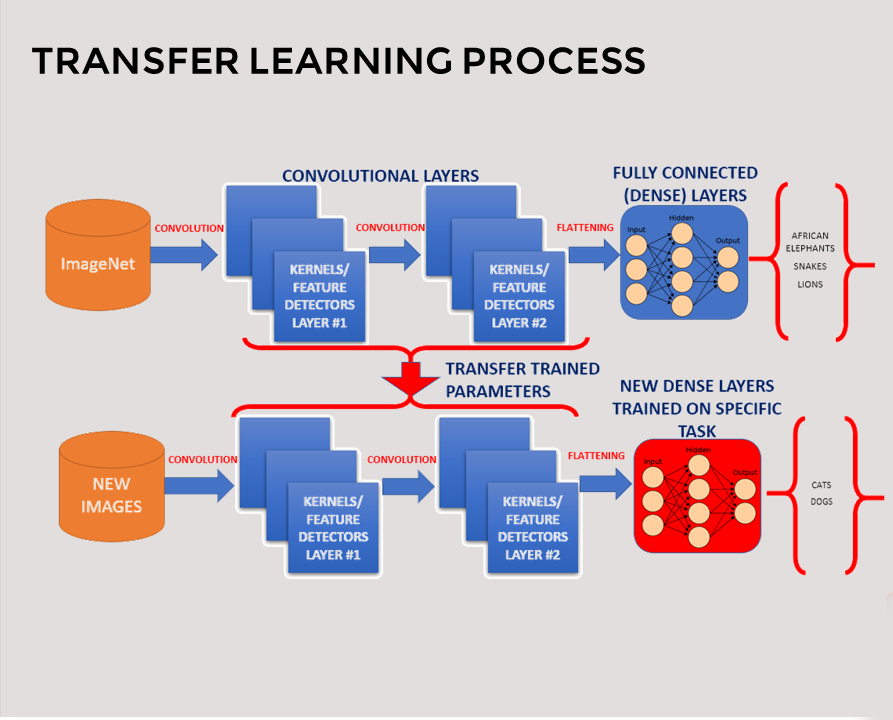

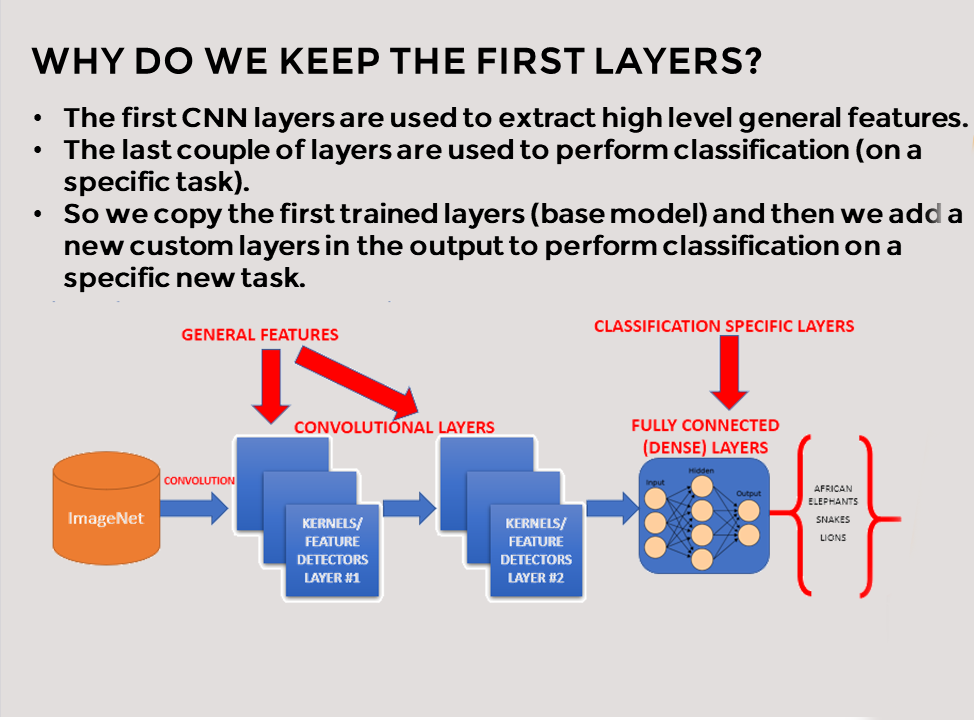

# 6: IMPORTING MODEL WITH PRETRAINED WEIGHTS

In [ ]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
#freezing the model upto the last stage - 4 and re-training stage -5 

for layer in basemodel.layers[:-10]:
  layers.trainable = False

# 7: BUILDING AND TRAINING DEEP LEARNING MODEL

In [ ]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = "relu")(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay = 1e-6), metrics= ["accuracy"])

In [ ]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training")
val_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="validation")

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 10, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
107/107 [==============================] - 158s 1s/step - loss: 1.0567 - accuracy: 0.6392 - val_loss: 6.2981 - val_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 6.29808, saving model to weights.hdf5
Epoch 2/10
107/107 [==============================] - 13s 121ms/step - loss: 0.5549 - accuracy: 0.7835 - val_loss: 6.9832 - val_accuracy: 0.2500

Epoch 00002: val_loss did not improve from 6.29808
Epoch 3/10
107/107 [==============================] - 13s 122ms/step - loss: 0.2434 - accuracy: 0.9322 - val_loss: 9.1482 - val_accuracy: 0.2500

Epoch 00003: val_loss did not improve from 6.29808
Epoch 4/10
107/107 [==============================] - 13s 123ms/step - loss: 0.1545 - accuracy: 0.9380 - val_loss: 5.2112 - val_accuracy: 0.2500

Epoch 00004: val_loss improved from 6.29808 to 5.21117, saving model to weights.hdf5
Epoch 5/10
107/107 [==============================] - 13s 121ms/step - loss: 0.2446 - accuracy: 0.9209 - val_loss: 7.2406 - val_accuracy: 0.2500

Epoc

# 8: EVALUATING TRAINED DEEP LEARNING MODEL

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

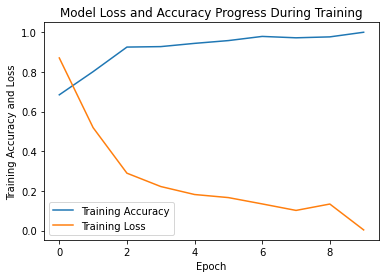

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('Model Loss and Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy and Loss')
plt.legend(['Training Accuracy', 'Training Loss'])

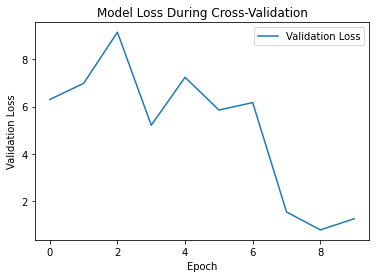

In [ ]:
plt.plot(history.history['val_loss'])
plt.title('Model Loss During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(['Validation Loss'])

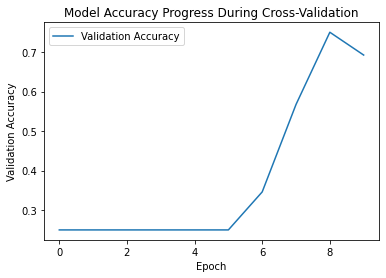

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation Accuracy'])

In [ ]:
test_directory = '/content/drive/My Drive/Colab Notebooks/Chest_X_Ray/Test'


In [ ]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 40, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 40 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


10/10 [==============================] - 2s 3ms/step - loss: 1.9120 - accuracy: 0.5500
Accuracy Test : 0.550000011920929


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [ ]:
len(original)

40

In [ ]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.525


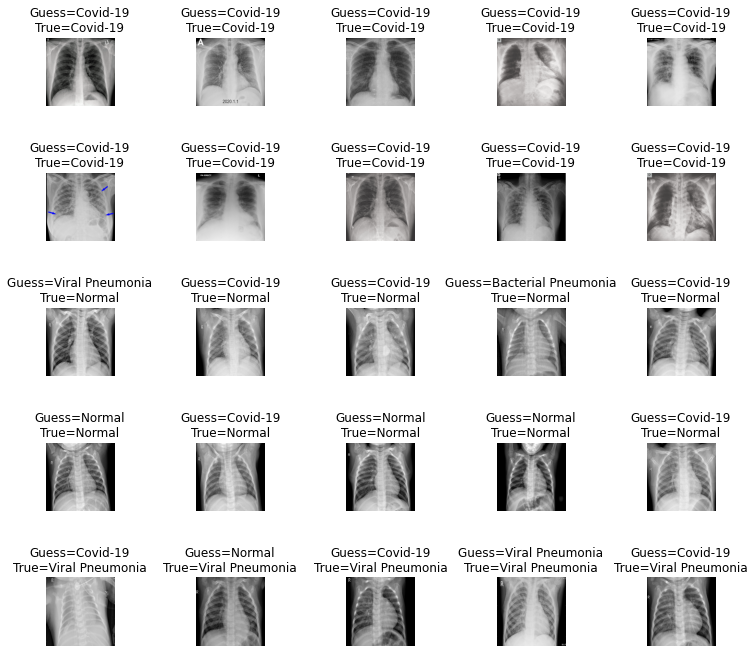

In [ ]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [ ]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.38      1.00      0.56        10
           1       0.75      0.30      0.43        10
           2       0.83      0.50      0.62        10
           3       0.75      0.30      0.43        10

    accuracy                           0.53        40
   macro avg       0.68      0.53      0.51        40
weighted avg       0.68      0.53      0.51        40



Text(0.5, 1.0, 'Confusion_matrix')

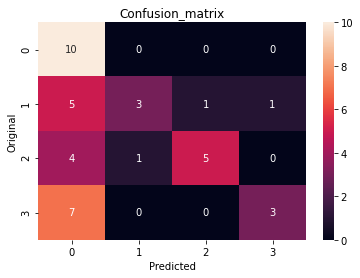

In [ ]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')

# THANK YOU
  Q AND A???